## Shell User Identification

The goal of this project is to find the count of the distinct users that accessed a distant computer, whom we have some the shell sessions transcripts.
Thus we will build a model that shall fit our data and from it we will infer the count.

We will treat our list of sessions as a corpus of texts and apply some of the classical NLP methods on it.
We have several reasons to believe that treating our sessions as natural language is coherent. Indeed, each session shares some properties with, for example, a piece of news:
- **chronological ordering**: the set of commands cannot always be put in a different order
- **terms co-occurence**: some words will appear together more often than others
- **session global topic**: a session will often be about on topic/discipline (network/math/...) linked to some of its commands 
- **stopwords**: most of our command flags are useless to get the meaning of the set of terms, in the same way that "the" can be useless in english

We choose the following model as a probabilistic generator explanation for the observed data:
- each user has a set of skills like network/science/file exploration/... (Alan is 30% network and 70% science, etc)
- each skill has a set of words commands/terms related to it (network -> telnet, science -> matlab, ...)
- each session, belonging to a user, is a draw between the different kind of skills the user has:   
  1. We draw the different topics from the user as a normal distribution around his skills profile
  2. Each session is drawn from a Dirichlet distribution between the different skills/discipline that we got a the previous step
  
To infer the hyper-parameters of this model (number of topics and number of users), we will first execute the fitting of a Latent Dirichlet Allocation on the content of the sessions, this will give us a distribution of topics/skills for each session. Then, we will infer the users profile using a Gaussian Mixture Model.

In [1]:
# Plot imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm, tqdm_notebook

# Metrics/model selection
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score

# NLP/Frequence-related import
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Data cleaning imports
import re
from nltk.metrics.distance import edit_distance

### Sessions text pre-processing

First, we need to apply some of our Unix knowledge to the data: some terms will be useful to indicate a user behavior and some will not.
For example, the name of a parameter is not really important, since the main piece of information is the program name preceding it. Therefore, we will replace all -k -a -p ..., by the token \_dashedarg\_.

In this cell, we handle the cleaning, tokenization, regex replacements of our word features so that the next layers of our model may better handle their input.

In [4]:
with open("./sessions.txt") as f:
    raw_data = f.read()[1:]
    
cleaned_data = list(t.strip(' ').strip('\n') for t in re.split(r"#eof#\n#bof#\n", raw_data[6:-6].lower()) if len(t) > 0)  

# We spotted some phone numbers, we replace them by a unique token
cleaned_sessions = [re.sub("#\+\d{5,}", "_phone_number_", d) for d in cleaned_data]

# Parameters to a unique token
cleaned_sessions = [re.sub("\s[-][a-zA-Z0-9_-]+", " _dashedarg_ ", d) for d in cleaned_sessions]

# Gensym tokens of the form <gensym:NOMBRE> par <gensym>
cleaned_sessions = [re.sub("<gensym:\d+>/?", " <gensym> ", d) for d in cleaned_sessions]

# Numbers of more than 2 digits
cleaned_sessions = [re.sub("(\d\d+)", " _bignumber_ ", d) for d in cleaned_sessions]

# FILENAME.EXTENSION by FILENAME EXTENSION so that extensions can be treated as an feature of their own
cleaned_sessions = [re.sub("([a-zA-Z0-9_-]*)\.(\w+)", " \g<1> <\g<2>_extension> ", d) for d in cleaned_sessions]

# The >/SOMETHING token to be treated as >/ and SOMETHING
cleaned_sessions = [re.sub(">[/]", " >/ ", d) for d in cleaned_sessions]

cleaned_sessions = [re.sub("[\n ]+", " ", d) for d in cleaned_sessions]
cleaned_sessions = cleaned_sessions

Count and make term frequencies for our words

In [5]:
first_vectorizer = CountVectorizer(
    max_df=0.95, min_df=0,
    max_features=1000, token_pattern='[^ ]+')
sessions_tf = first_vectorizer.fit_transform(cleaned_sessions)
n_sessions = len(cleaned_sessions)

Spot typos and replace them with a specific token (\_typo\_) so we can treat them as a common behavior

In [6]:
term_counts = np.array(sessions_tf.sum(axis=0).tolist()[0])
term_rarity_threshold = term_counts.mean() / 10

sessions_with_typos = []
for session in cleaned_sessions:
    words = session.split(' ')
    new_session = []
    for i, word in enumerate(words[0:-2]):
        # Look ahead of 2
        next_word = words[i+1]
        next_next_word = words[i+2]
        i1 = first_vectorizer.vocabulary_.get(word, None)
        i2 = first_vectorizer.vocabulary_.get(next_word, None)
        i3 = first_vectorizer.vocabulary_.get(next_next_word, None)
        
        if (i1 is not None and term_counts[i1] < term_rarity_threshold):
            if i2 is not None and term_counts[i2] > term_rarity_threshold and edit_distance(word, next_word) < min(len(word)/2+1, 5):
                new_session.append("_TYPO_")
                continue
            elif i3 is not None and term_counts[i3] > term_rarity_threshold and edit_distance(word, next_next_word) < min(len(word)/2+1, 5):
                new_session.append("_TYPO_")
                continue
        new_session.append(word)
    new_session.extend(words[-2:])
    sessions_with_typos.append(" ".join(new_session))

In [7]:
final_vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=1000,
    token_pattern='[^ ]+')
sessions_with_typo_tf = final_vectorizer.fit_transform(sessions_with_typos)

In [8]:
counts = np.array(sessions_with_typo_tf.mean(axis=0).tolist()).reshape(-1)
sorted(((word, counts[i]) for word, i in final_vectorizer.vocabulary_.items()), reverse=True, key=lambda x: x[1])[:5]

[('<1>', 12.407163441745617),
 ('cd', 4.248250308769005),
 ('ls', 2.601893783449965),
 ('_dashedarg_', 2.2704816797035705),
 ('<2>', 2.230547550432269)]

### Dimension reduction

We now have our term frequencies for all of our sessions:   
 - each session is now described by a vector whose dimension is approximately the size of our vocabulary.   
 - each vector cell represent the importance of the word in the session
 
However, despite the fact that our data is now modeled as contiuous vector, the dimension is still to high (~ 300 features vector space). Because of the curse of high dimensionnality, we wont be able to apply any classical clustering technique to our matrix.
Thus, we will apply Latent Dirichlet Allocation, to represent each session by another vector in a space with fewer dimensions.

**How do we score a topic model ?**

Even with some knowledge about the Unix shell, it's not quite obvious:
- how correlated each topic is with a Unix sub-discipline (math/file management/network/...)
- is 12 the right number of topics ? or maybe 11 ?

We need a metric to help us decide. We could use the perplexity of the model, but this doesnt fit our goals.   
Indeed, the more topics we add, the easier it is for our model to represent any kind of irregularity, so the perplexity keeps dropping.
The issue here is that we didn't evaluate the model on a separated hold-out part of the dataset: we are going to make a K-Fold cross-validation and retain the best model against this metric

Make a KFold of 5 for the LDA

In [9]:
kfold_lda = RepeatedKFold(n_splits=5, n_repeats=4)

Scores perplexities of multiple LDAs for a number of topics ranging from 4 to 15

In [10]:
lda_perplexity = []

In [11]:
range_n_topics = range(4, 15)
for n_topics in tqdm_notebook(range_n_topics, leave=False):
    for split_i, (train_indexes, test_indexes) in tqdm_notebook(enumerate(kfold.split(sessions_with_typo_tf)), leave=False):
        lda = LatentDirichletAllocation(n_components=n_topics, learning_method='batch')
        lda.fit(sessions_with_typo_tf[train_indexes])
        lda_perplexity.append((n_topics, split_i,
                               lda.perplexity(sessions_with_typo_tf[train_indexes]),
                               lda.perplexity(sessions_with_typo_tf[test_indexes])))

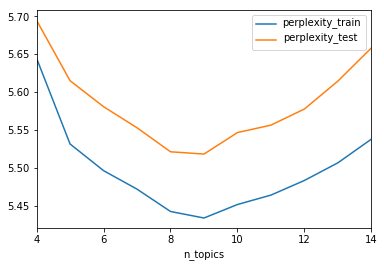

In [715]:
pd.DataFrame(lda_perplexity, columns=['n_topics', 'split_i', 'perplexity_train', 'perplexity_test'])\
    .set_index(['n_topics', 'split_i'])\
    .groupby('n_topics').mean().plot()

We can see that the best test perplexity occurs at n_topics = 9, both for the test and train set.
This is the value we are going to keep for our topic counts.

Now that we have decided for a number of topics to represent our sessions, we will make a final LDA to "factorize" our sessions.

In [28]:
FINAL_TOPICS_COUNT = 9

lda_final = LatentDirichletAllocation(n_components=FINAL_TOPICS_COUNT, learning_method='batch')
lda_final.fit(sessions_with_typo_tf)
session_topics = lda_final.transform(sessions_with_typo_tf)
score = lda_final.perplexity(sessions_with_typo_tf)

### Interactive PCA Visualization

This part is not essential, but it's always nice to have a way to look
at the model output in an interactive way. You will need to install

```pip install pyLDAvis```

to enjoy the show

In [14]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [29]:
pyLDAvis.sklearn.prepare(lda_final, sessions_with_typo_tf, final_vectorizer)

/Users/perceval/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      25.403071        1       1 -0.024685 -0.035659
3      23.952453        1       2 -0.130208 -0.025056
8      13.824440        1       3 -0.014867 -0.014659
2      13.572588        1       4  0.142982  0.036575
4       8.377632        1       5  0.040560 -0.155448
6       5.497569        1       6 -0.182501  0.162691
7       4.918389        1       7 -0.166172  0.178248
5       2.706325        1       8 -0.028055 -0.279455
1       1.747533        1       9  0.362948  0.132762, topic_info=     Category          Freq                     Term         Total  loglift  \
term                                                                          
22    Default   5468.000000                      <2>   5468.000000  30.0000   
45    Default   5618.000000              _dashedarg_   5618.000000  29.0000   
193   Default   6300.000000                       ls   6300.000000  28.0000   
200   Default   1571.000000                     make   1571.000000  27.0000   
21    Default  29902.000000                      <1>  29902.000000  26.0000   
146   Default   1678.000000                     grep   1678.000000  25.0000   
116   Default   1311.000000                      elm   1311.000000  24.0000   
181   Default   1346.000000                     less   1346.000000  23.0000   
73    Default  10283.000000                       cd  10283.000000  22.0000   
184   Default   3594.000000                       ll   3594.000000  21.0000   
36    Default    717.000000          <out_extension>    717.000000  20.0000   
48    Default    679.000000                        a    679.000000  19.0000   
211   Default   1176.000000                     more   1176.000000  18.0000   
12    Default    832.000000                        -    832.000000  17.0000   
107   Default   1453.000000                      dir   1453.000000  16.0000   
131   Default    675.000000                       fg    675.000000  15.0000   
20    Default    747.000000                        <    747.000000  14.0000   
34    Default    478.000000                 <gensym>    478.000000  13.0000   
129   Default    573.000000                        f    573.000000  12.0000   
227   Default    660.000000                   parsec    660.000000  11.0000   
6     Default    489.000000                        &    489.000000  10.0000   
327   Default   4367.000000                       vi   4367.000000   9.0000   
255   Default    486.000000                   rlogin    486.000000   8.0000   
71    Default    677.000000                      cat    677.000000   7.0000   
135   Default    443.000000                   finger    443.000000   6.0000   
186   Default    508.000000                       lo    508.000000   5.0000   
189   Default    560.000000                   logout    560.000000   4.0000   
126   Default    491.000000                     exit    491.000000   3.0000   
180   Default    603.000000                    latex    603.000000   2.0000   
274   Default    268.000000                   setenv    268.000000   1.0000   
...       ...           ...                      ...           ...      ...   
219    Topic9      2.344531                     nire      3.230697   3.7264   
34     Topic9    309.533256                 <gensym>    478.072668   3.6123   
25     Topic9     62.528263                      <5>    107.172913   3.5081   
336    Topic9     45.187603                      who     99.974683   3.2529   
334    Topic9     39.995726                    which     97.411784   3.1568   
203    Topic9     41.839673                   matlab    117.347516   3.0157   
6      Topic9    170.556690                        &    489.749290   2.9921   
240    Topic9     35.794473                       ps    165.199446   2.5176   
172    Topic9     43.400989                     jobs    262.759274   2.2462   
71     Topic9    101.680637                  

### t-SNE topic visualization

Though we got a good grasp of the different topics distribution with pyLDAvis through PCA decomposition, we can also see try to see what our topics looks like using t-SNE with is another, probabilistic however, reduction process. Here, we can clearly see that some of the sessions are grouped together, could it be the sign of different users ?

We will proceed to apply clustering techniques to find out.

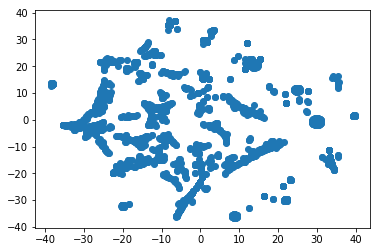

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, n_iter=400)
tsne_results = tsne.fit_transform(session_topics)

vis_x = tsne_results[:, 0]
vis_y = tsne_results[:, 1]

plt.scatter(vis_x, vis_y)
plt.show()

### Gaussian Mixture Model to infer the user profiles

Now that we have decomposed our corpus into vector of fewer dimensions, we can try to find some close behaviors, ie infer some users profile. For that, we said that we would need to use a Gaussian Mixture Model. However, we need to know how many users we want to apply this model to.

Again, we are going to execute the fitting for a range of cluster counts and use some criterion to choose between these models. Some of the criterions we can use are:
- **per-sample average test log-likelyhood**: how well the different gaussian explain test data from a K-Fold
- **calinsky-harabaz**: a ratio between intra-cluster and inter-cluster dispersions. This will give good score to tight, gaussian like, well separated clusters. We apply this on all data because we want to rate the shape of the complete clusters
- **silhouette**: calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample, this will give a high score when our clusters are non overlapping. Same as before, we apply this on all the data

The last two criterion focus on giving homogenous/tight and distinct clusters. This is not our ultimate goal but those are good indicators, since multiple users can indeed have very similar sessions sometimes.

However, we note that as the number of cluster grows, so does the log-likelyhood: with more clusters, we give the model more flexibility to represent distant, isolated samples of hold-out data samples. We would like to penalize in some way the size of our model.   
This done by the  **Aikaike Information Criterion** (AIC) and the **Bayesian Information Criterion** (BIC), that gives the log-likelyhood minus a term using the number of parameters. The later makes more sense in our case because we are modelling Gaussian Mixtures.

Our goal will then be to spot the moment when adding a new cluster will not help our model improve the (corrected or not) test log-likelyhood.

In [30]:
import sklearn.mixture
import sklearn.model_selection

kfold_clusters = sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=5)
n_splits = kfold_clusters.get_n_splits(session_topics)

cluster_data = []

for n_clusters in tqdm_notebook(range(4, 25)):
    for split_i, (train_indexes, test_indexes) in tqdm_notebook(enumerate(kfold_clusters.split(session_topics)), leave=False, total=n_splits):
        model = sklearn.mixture.GaussianMixture(n_components=n_clusters, max_iter=400)
        model.fit(session_topics[train_indexes])
        labels = model.predict(session_topics[test_indexes])
        all_labels = model.predict(session_topics)
        cluster_data.append((n_clusters,
                             model.bic(session_topics[test_indexes]),
                             silhouette_score(session_topics, all_labels),
                             calinski_harabaz_score(session_topics, all_labels)))

In [31]:
df_users = pd.DataFrame(cluster_data, columns=['n_users', 'bic', 'silhouette', 'ch'])
df_users = df_users.set_index('n_users').groupby(level=0).mean()

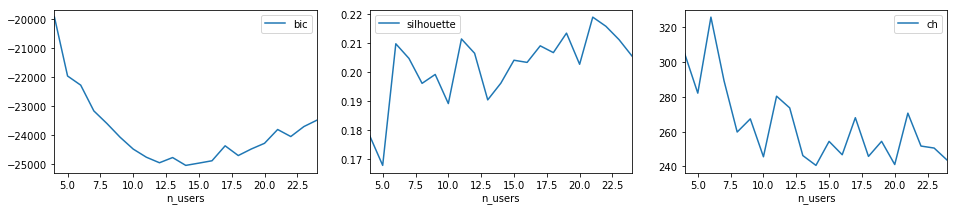

In [47]:
plt.figure(figsize=(16, 3))
ax = plt.subplot(1, 3, 1)
df_users.loc[:, ['bic']].plot(ax=ax)
ax = plt.subplot(1, 3, 2)
df_users.loc[:, ['silhouette']].plot(ax=ax)
ax = plt.subplot(1, 3, 3)
df_users.loc[:, ['ch']].plot(ax=ax)
plt.show()

Depending on the LDA output, we can see that the log-likelyhood scores stop improving after 8 to 12 users (especially BIC), and this value is coherent with the silhouette and calinsky-harabaz scores that features a high values between 8-12 also.

Lets take 10 as an answer

In [36]:
FINAL_USERS_COUNT = 8
final_gm = sklearn.mixture.GaussianMixture(n_components=FINAL_USERS_COUNT, max_iter=400)
final_gm.fit(session_topics)
final_labels = final_gm.predict(session_topics)

### Topic visualization

Though we got a good grasp of the different topics distribution with pyLDAvis through PCA decomposition, we can also see try to see what our topics looks like using t-SNE with is another, probabilistic however, reduction process. Here, we can clearly see that some of the sessions are grouped together, could it be the sign of different users ?

We will proceed to apply clustering techniques to find out.

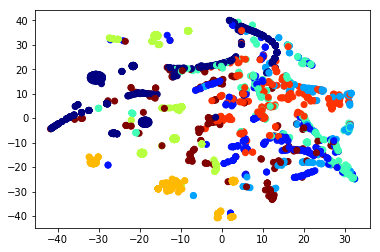

In [37]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=25, n_iter=400)
tsne_results = tsne.fit_transform(session_topics)

vis_x = tsne_results[:, 0]
vis_y = tsne_results[:, 1]

plt.scatter(vis_x, vis_y, c=final_labels, cmap=plt.cm.get_cmap("jet", FINAL_USERS_COUNT))
plt.show()

In [41]:
def show_class(label=0):
    subset = np.argwhere(final_labels == label).reshape(-1)
    vis_x = tsne_results[:, 0]
    vis_y = tsne_results[:, 1]

    colors = np.zeros((len(final_labels),),)
    colors[subset] = 10
    plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap("viridis", FINAL_USERS_COUNT))
    plt.clim(-0.5, 9.5)
    plt.show()

In [39]:
from ipywidgets import interactive

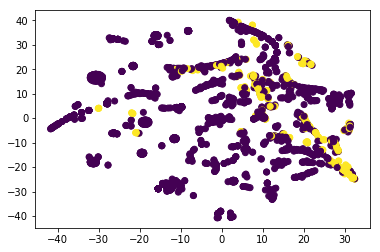

In [40]:
interactive_plot = interactive(show_class, label=(0, FINAL_USERS_COUNT, 1), style="width:300px")
interactive_plot